In [15]:
##Including Imports
import pandas as pd
import math
import numpy as np
import mpu
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
from distfit import distfit
from pprint import pprint

In [3]:
data = pd.read_csv("data.csv")
df = data.drop(data.columns[[11, 12, 13, 14]], axis=1)
df.head()

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR.1,TYPE,MAG
0,16957943,ISC,1907-01-04,05:19:11.80,1.8725,94.2091,15.0,TRUE,ISC,MS,7.8
1,913990,ISC,1914-06-25,19:07:25.91,-3.9242,101.8203,35.0,TRUE,ISC,MS,7.6
2,913286,ISC,1918-09-22,09:55:00.13,-1.4570,100.0902,35.0,TRUE,ISC,MS,6.5
3,912712,ISC,1919-01-18,05:52:24.87,-4.5766,101.4670,35.0,TRUE,ISC,MS,6.3
4,912756,ISC,1919-04-02,00:34:59.58,-5.4963,104.4870,20.0,TRUE,ISC,MS,6.5


In [4]:
#Current Dimension of DataFrame
df.shape

(347, 11)

In [5]:
def get_dist(lat1, lang1, lat2, lang2):
    dist = mpu.haversine_distance((lat1, lang1), (lat2, lang2))
    return abs(dist)

def get_diff_days(date1, date2):
    date_format = "%Y-%m-%d"
    return abs((datetime.strptime(date1, date_format) - datetime.strptime(date2, date_format)).days)
    
def get_window(M):
    r = math.exp(-1.024 + 0.804 * M)
    t = math.exp(-2.870 + 1.235 * M)
    return r, t

def filtering(df):
    for index1, row1 in df.iterrows():
        M = row1["MAG"]
        r = math.exp(-1.024 + 0.804 * M)
        t = math.exp(-2.870 + 1.235 * M)
        for index2, row2 in df.iterrows():
            if (row2["MAG"] <= row1["MAG"] and (index1 is not index2) and 
                    (get_dist(row1["LAT"], row1["LON"], row2["LAT"], row2["LON"]) <= r+60) 
                       and (get_diff_days(row1["DATE"], row2["DATE"]) <= t+15)):
                    df.drop(index2,inplace=True)

In [6]:
filtering(df)

In [7]:
df.head()

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR.1,TYPE,MAG
0,16957943,ISC,1907-01-04,05:19:11.80,1.8725,94.2091,15.0,TRUE,ISC,MS,7.8
1,913990,ISC,1914-06-25,19:07:25.91,-3.9242,101.8203,35.0,TRUE,ISC,MS,7.6
2,913286,ISC,1918-09-22,09:55:00.13,-1.4570,100.0902,35.0,TRUE,ISC,MS,6.5
3,912712,ISC,1919-01-18,05:52:24.87,-4.5766,101.4670,35.0,TRUE,ISC,MS,6.3
4,912756,ISC,1919-04-02,00:34:59.58,-5.4963,104.4870,20.0,TRUE,ISC,MS,6.5


In [8]:
#Current shape of DataFrame
df.shape

(164, 11)

In [9]:
date_format = "%Y/%m/%d"

int_time = []
int_time.append(0)
date_values = df["DATE"].values
for i in range(len(date_values)):
    if(i != 0):
        int_time.append(get_diff_days(date_values[i], date_values[i-1]))

df["INTEREVENT TIME"] = int_time
df["INTEREVENT TIME"] /= (12*30)
df = df[df["INTEREVENT TIME"] != 0]

In [10]:
df.head()

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR.1,TYPE,MAG,INTEREVENT TIME
1,913990,ISC,1914-06-25,19:07:25.91,-3.9242,101.8203,35.0,TRUE,ISC,MS,7.6,7.580556
2,913286,ISC,1918-09-22,09:55:00.13,-1.4570,100.0902,35.0,TRUE,ISC,MS,6.5,4.305556
3,912712,ISC,1919-01-18,05:52:24.87,-4.5766,101.4670,35.0,TRUE,ISC,MS,6.3,0.327778
4,912756,ISC,1919-04-02,00:34:59.58,-5.4963,104.4870,20.0,TRUE,ISC,MS,6.5,0.205556
5,912979,ISC,1919-10-12,21:48:31.74,-4.1786,101.7521,25.0,TRUE,ISC,MS,6.5,0.536111


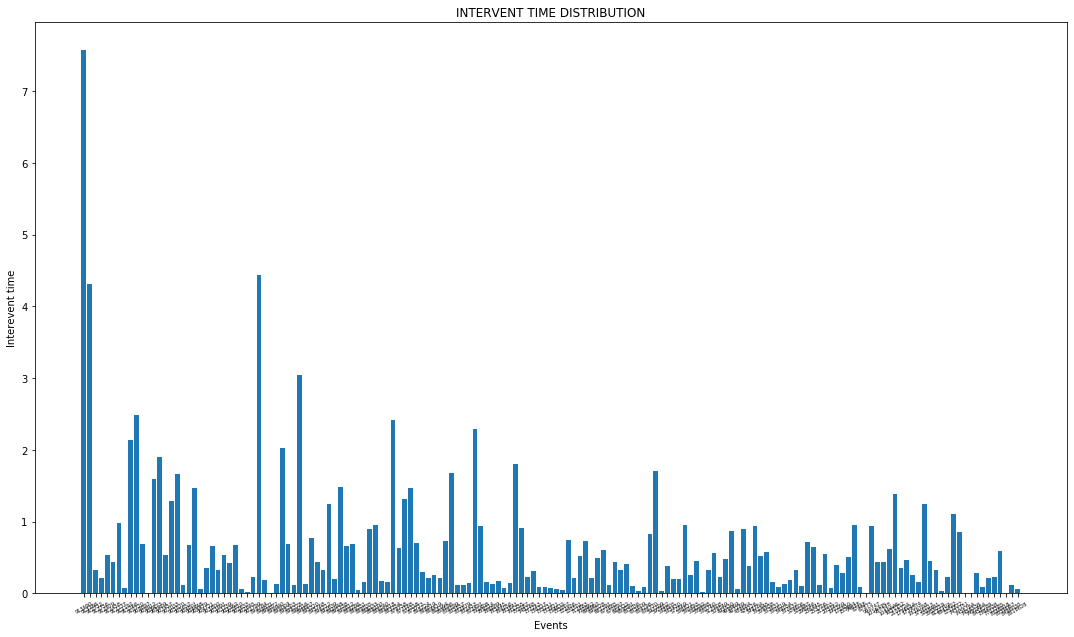

In [11]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

index = np.arange(len(df))
plt.xlabel('Events', fontsize=10)
plt.ylabel('Interevent time', fontsize=10)
plt.xticks(index, df["EVENTID"].values, fontsize=5, rotation=30)
plt.title('INTERVENT TIME DISTRIBUTION')
plt.bar(index, df["INTEREVENT TIME"])
plt.show()

In [12]:
df2 = pd.DataFrame()
df2["INTEREVENT TIME"] = df["INTEREVENT TIME"]
df2.to_csv("interevent_time.csv")

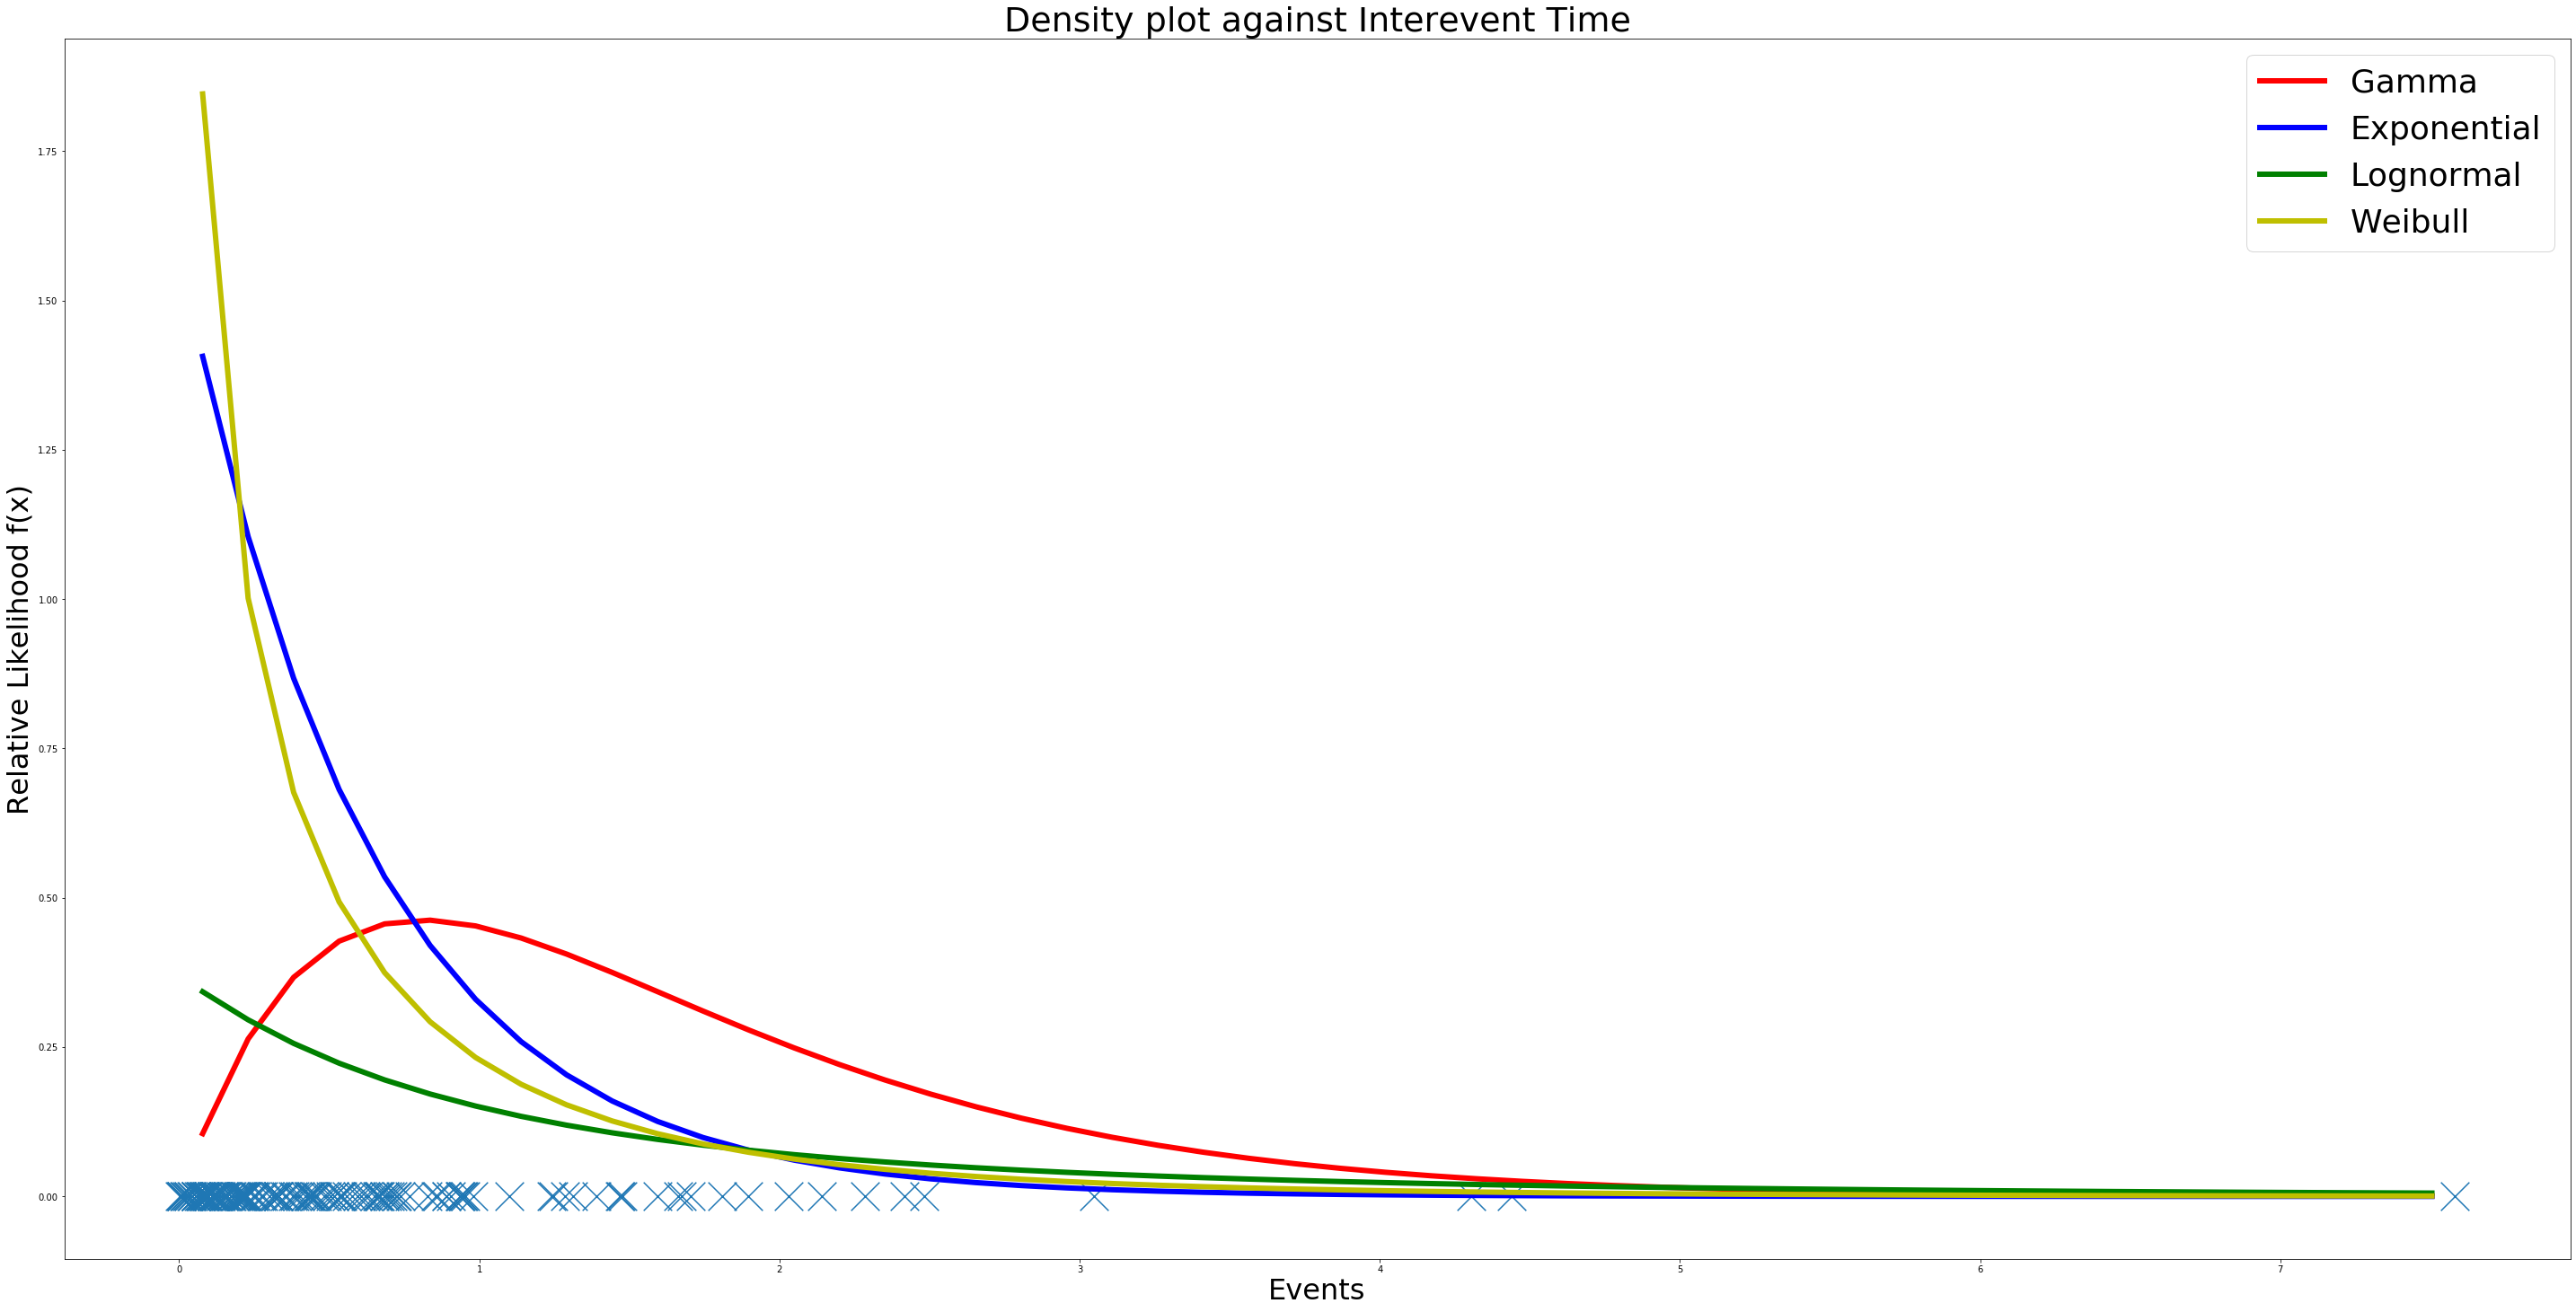

In [26]:
##MoM
fig = plt.gcf()
fig.set_size_inches(50, 25, forward=True)

index = np.arange(len(df))
plt.xlabel('Events', fontsize=32)
plt.ylabel('Relative Likelihood f(x)', fontsize=32)
plt.title('Density plot against Interevent Time', fontsize =38)
plt.scatter(df["INTEREVENT TIME"], np.zeros(len(df)), s = 1000, marker= 'x')
plt.plot(x, stats.gamma.pdf(x, a = (1/0.4913494), scale=0.7833695), "r", linewidth=6, label = "Gamma")
plt.plot(x, stats.expon.pdf(x, scale = (1/1.594322)), "b", linewidth=6, label = "Exponential")
plt.plot(x, stats.lognorm.pdf(x, loc = -1.021589, s = 1.053699), "g", linewidth=6, label = "Lognormal")
plt.plot(x, stats.weibull_min.pdf(x, c = 0.7153732, scale = 0.5056480), "y", linewidth=6, label = "Weibull")
plt.legend(prop={'size': 36})
plt.show()

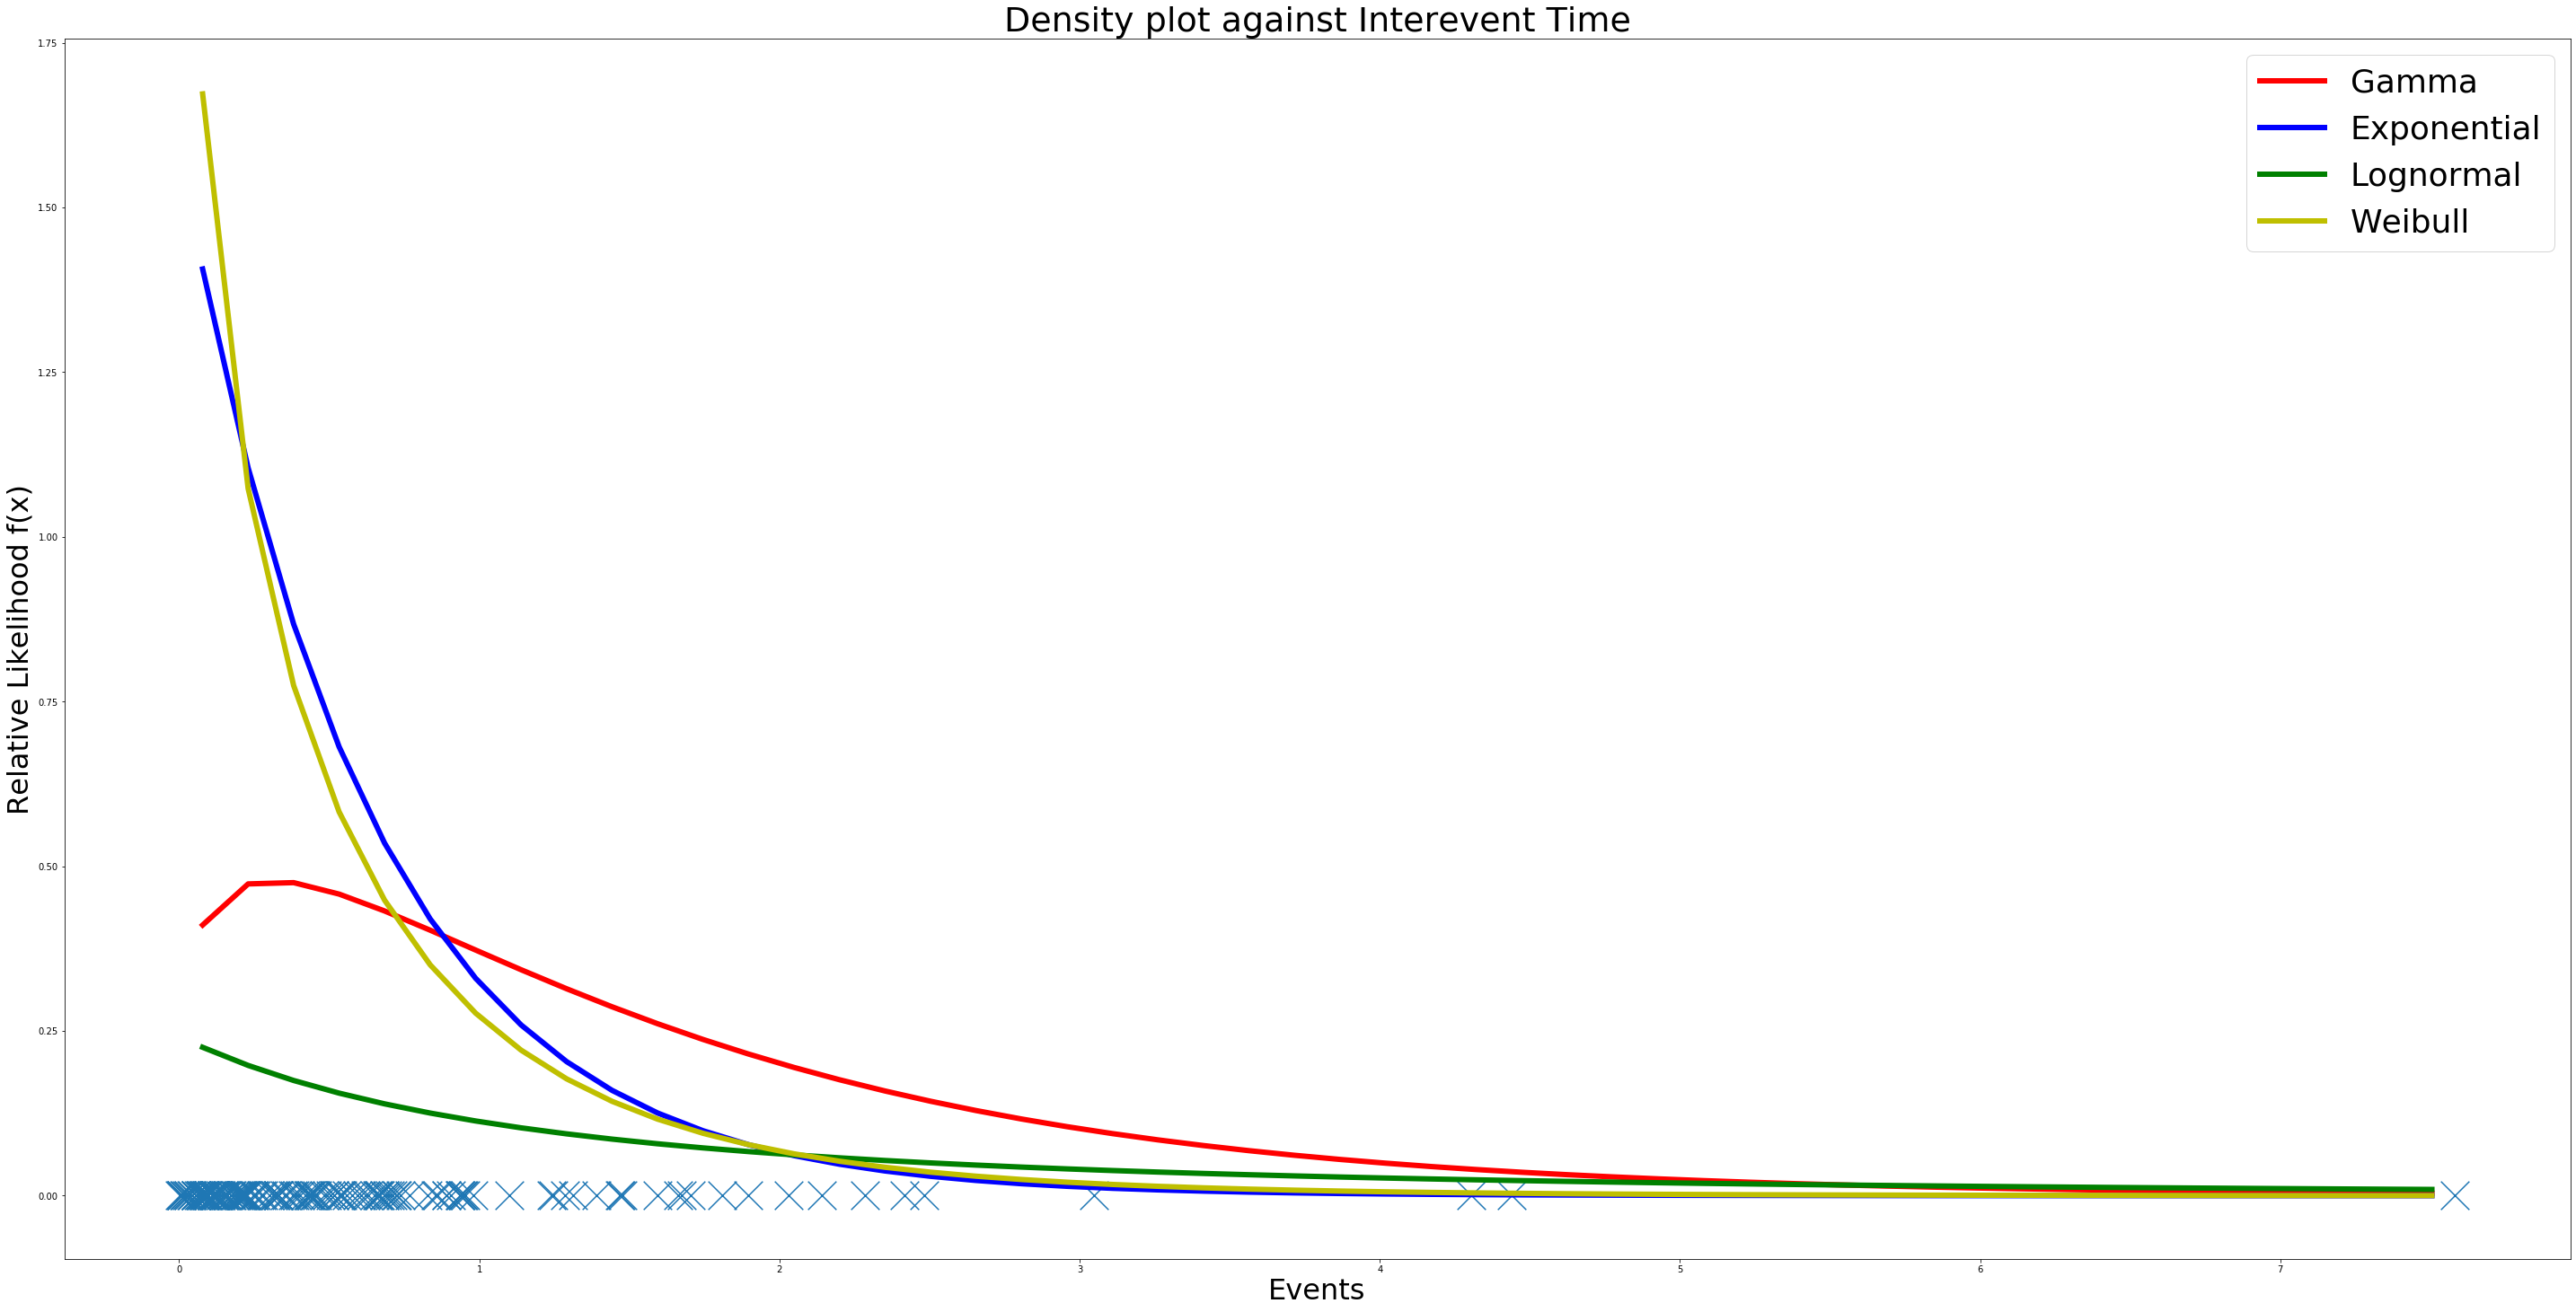

In [23]:
##MLE
fig = plt.gcf()
fig.set_size_inches(50, 25, forward=True)

index = np.arange(len(df))
plt.xlabel('Events', fontsize=32)
plt.ylabel('Relative Likelihood f(x)', fontsize=32)
plt.title('Density plot against Interevent Time', fontsize =38)
plt.scatter(df["INTEREVENT TIME"], np.zeros(len(df)), s = 1000, marker= 'x')
plt.plot(x, stats.gamma.pdf(x, a = (1/0.8055547), scale = 1.2842414), "r", label = "Gamma", linewidth=6)
plt.plot(x, stats.expon.pdf(x, scale = (1/1.594322)), "b", label = "Exponential", linewidth=6)
plt.plot(x, stats.lognorm.pdf(x, loc = -1.202592, s = 1.359600), "g", label = "Lognormal", linewidth=6)
plt.plot(x, stats.weibull_min.pdf(x, c = 0.8456672, scale = 0.5691232), "y", label = "Weibull", linewidth=6)
plt.legend(prop={'size': 36})
plt.show()

('For exponential: MLE parameters = (0.0, 0.13196480938416422) and K-S test '
 'results = KstestResult(statistic=0.58, pvalue=1.715513401942916e-16)')
('For gamma: MLE parameters = (0.48858524007451876, -4.236927929535989e-31, '
 '0.713320440439315) and K-S test results = '
 'KstestResult(statistic=0.5799999999999981, pvalue=1.7155134019433704e-16)')
('For weibull: MLE parameters = (1.3556343191366995, 0.5009602129189118, '
 '-1.900433041230768e-30, 0.022137446382910004) and K-S test results = '
 'KstestResult(statistic=0.58, pvalue=1.715513401942916e-16)')
('For lognormal: MLE parameters = (14.22220606440456, -6.563384279808368e-23, '
 '0.04441457209249096) and K-S test results = '
 'KstestResult(statistic=0.5796274949527684, pvalue=1.8075249940241597e-16)')


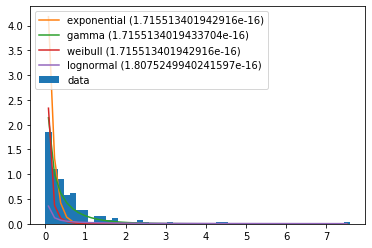

In [16]:
data = pd.read_csv('interevent_time.csv', names=['index', 'interevent_time'], skiprows=1)
data = data['interevent_time']
y, x = np.histogram(data, bins=50, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

dists = {
    'exponential': st.expon,
    'gamma': st.gamma,
    'weibull': st.exponweib,
    'lognormal': st.lognorm
}

plt.hist(data, bins=50, density=True, label='data')
for i, (name, dist) in enumerate(dists.items()):
    args = dist.fit(y)
    prob = st.kstest(y, dist.cdf, args)
    pprint(f'For {name}: MLE parameters = {args} and K-S test results = {prob}')
# Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *args[:-2], loc=args[-2], scale=args[-1])

    # Add the line to the plot
    plt.plot(x, pdf_fitted, label=f'{name} ({prob[-1]})')

plt.legend(loc='upper left')
plt.show()

In [27]:
def cdf_exponential_mle(t):
    return stats.expon.cdf(t, scale = (1/1.59432))

def cdf_gamma_mle(t):
    return stats.gamma.cdf(t, a = (1/0.8055547), scale = 1.2842414)

def cdf_lnorm_mle(t):
    return stats.lognorm.cdf(t, loc = -1.202592, s = 1.359600)

def cdf_weibull_mle(t):
    return stats.weibull_min.cdf(t, c = 0.8456672, scale = 0.5691232)

def cdf_exponential_mom(t):
    return stats.expon.cdf(t, scale = (1/1.594322))

def cdf_gamma_mom(t):
    return stats.gamma.cdf(t, a = (1/0.4913494), scale = 0.7833695)

def cdf_lnorm_mom(t):
    return stats.lognorm.cdf(t, loc = -1.021589, s = 1.053699)

def cdf_weibull_mom(t):
    return stats.weibull_min.cdf(t, c = 0.7153732, scale = 0.5056480)

def c_prob(v, cdf, t):
    return (cdf(t+v) - cdf(t)) / (1 - cdf(t))

In [29]:
v = np.arange(0, 50, 0.001)

In [30]:
def plot_mle(elapsed_times, v):  
    fig = plt.gcf()
    fig.set_size_inches(18, 15, forward=True)
    
    plt.figure(figsize=(12,8))
    plt.subplot(221)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_exponential_mle, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Exponential')
    plt.subplot(222)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_gamma_mle, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Gamma')
    plt.subplot(223)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_lnorm_mle, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Lognormal')
    plt.subplot(224)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_weibull_mle, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Weibull')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.suptitle('Conditional Probability Curves For MLE parameters', fontsize = 15)
    plt.show()
    
def plot_mom(elapsed_times, v):  
    fig = plt.gcf()
    fig.set_size_inches(18, 15, forward=True)
    
    plt.figure(figsize=(12,8))
    plt.subplot(221)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_exponential_mom, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Exponential')
    plt.subplot(222)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_gamma_mom, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Gamma')
    plt.subplot(223)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_lnorm_mom, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Lognormal')
    plt.subplot(224)
    for t in elapsed_times:
        plt.plot(v+t, c_prob(v, cdf_weibull_mom, t), "b")
        plt.xlabel('Elapsed Time', fontsize=10)
        plt.ylabel('Conditional Probability', fontsize=10)
        plt.title('Weibull')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.suptitle('Conditional Probability Curves For MOM parameters', fontsize = 15)
    plt.show()

<Figure size 1296x1080 with 0 Axes>

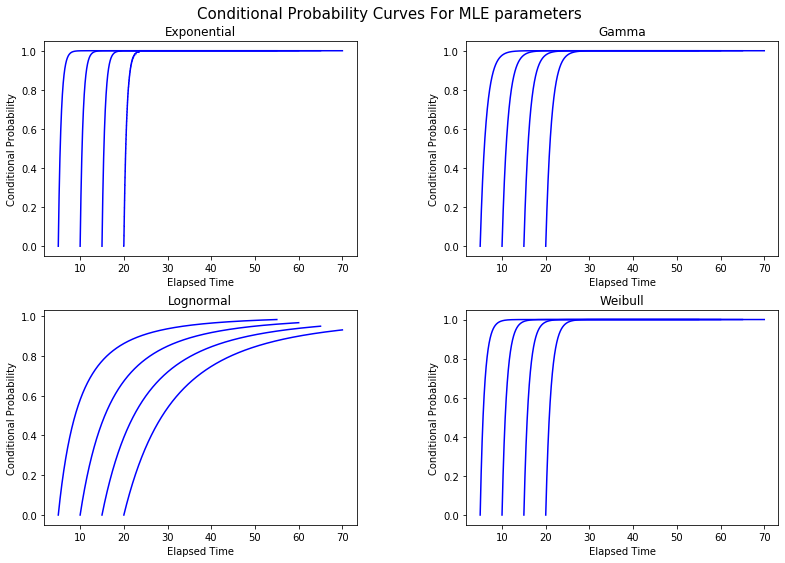

<Figure size 1296x1080 with 0 Axes>

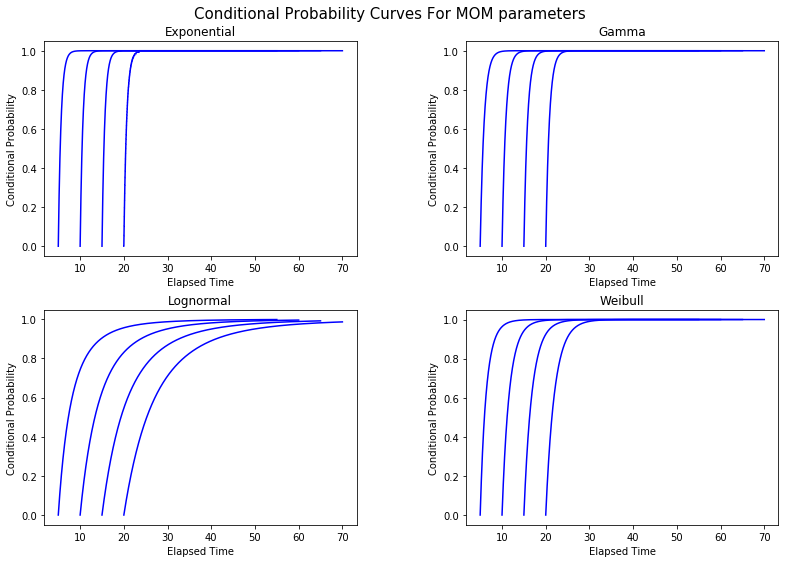

In [37]:
plot_mle([5, 10, 15, 20], v)
plot_mom([5, 10, 15, 20], v)